In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import open3d as o3d
from pathlib import Path
import pandas as pd
import segment
from scipy import ndimage as ndi
from skimage import color, feature, filters, morphology, measure, segmentation, util
from stl import mesh
import sys
import yaml
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load in Images

Loading images...
--> Images loaded as 3D array:  (350, 1024, 1004)
--> Size of array (GB):  0.7196672
Plotting images: [100, 150, 200, 250]


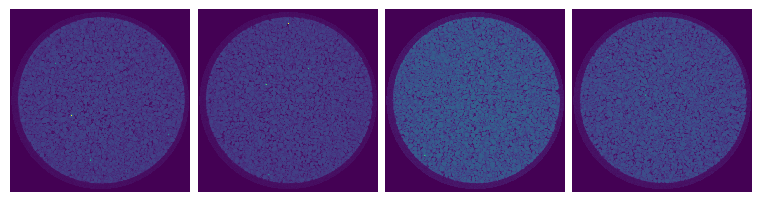

In [2]:
# Read YAML input file
yaml_file = Path(r'C:\Users\gusb\Research\PSAAP\segmentflow-input-gus.yml')
stream = open(yaml_file, 'r')
UI = yaml.load(stream,Loader=yaml.FullLoader)   # User Input
stream.close()
# Process User Input
ui_ct_img_dir           = UI['Files']['CT Scan Dir']
ui_stl_dir_location     = UI['Files']['STL Dir']
ui_output_filename_base = UI['Files']['STL Prefix']
ui_stl_overwrite        = UI['Files']['Overwrite Existing STL Files']
ui_single_particle_iso  = UI['Files']['Particle ID']
ui_suppress_save_msg    = UI['Files']['Suppress Save Messages']
ui_file_suffix          = UI['Load']['File Suffix']
ui_slice_crop           = UI['Load']['Slice Crop']
ui_row_crop             = UI['Load']['Row Crop']             
ui_col_crop             = UI['Load']['Col Crop']
ui_use_median_filter    = UI['Preprocess']['Apply Median Filter']
ui_rescale_range        = UI['Preprocess']['Rescale Intensity Range']
ui_n_otsu_classes       = UI['Binarize']['Number of Otsu Classes']
ui_n_selected_classes   = UI['Binarize']['Number of Classes to Select']
ui_use_int_dist_map     = UI['Segment']['Use Integer Distance Map']
ui_min_peak_distance    = UI['Segment']['Min Peak Distance']
ui_exclude_borders      = UI['Segment']['Exclude Border Particles']
ui_n_erosions           = UI['STL']['Number of Pre-Surface Meshing Erosions']    
ui_median_filter        = UI['STL']['Smooth Voxels with Median Filtering']
ui_spatial_res          = UI['STL']['Pixel-to-Length Ratio']
ui_voxel_step_size      = UI['STL']['Marching Cubes Voxel Step Size']    
ui_mesh_smooth_n_iters  = UI['STL']['Number of Smoothing Iterations']  
ui_mesh_simplify_n_tris = UI['STL']['Target number of Triangles/Faces']
ui_mesh_simplify_factor = UI['STL']['Simplification factor Per Iteration']
ui_show_segment_fig     = UI['Plot']['Show Segmentation Figure']
ui_n_imgs               = UI['Plot']['Number of Images']
ui_plot_maxima          = UI['Plot']['Plot Maxima']
ui_show_label_fig       = UI['Plot']['Show Particle Labels Figure']
ui_label_idx            = UI['Plot']['Particle Label Image Index']
ui_show_stl_fig         = UI['Plot']['Show Random STL Figure']
# Load images
print('Loading images...')
imgs = segment.load_images(
    ui_ct_img_dir,
    slice_crop=ui_slice_crop,
    row_crop=ui_row_crop,
    col_crop=ui_col_crop,
    convert_to_float=True,
    file_suffix=ui_file_suffix
)
print('--> Images loaded as 3D array: ', imgs.shape)
print('--> Size of array (GB): ', imgs.nbytes / 1E9)
# Plot images
fig, axes = segment.plot_imgs(imgs, slices=[100, 150, 200, 250])
plt.show()

## Add preprocessing step

### Median filter followed by intensity rescale

Preprocessing images...
Applying median filter...
Rescaling intensities to percentile range         [5, 95]...
--> Preprocessing complete
--> Size of array (GB):  0.7196672
Plotting images: [100, 150, 200, 250]


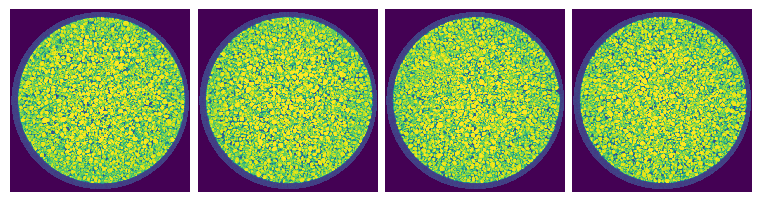

In [3]:
print('Preprocessing images...')
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=ui_rescale_range
)
print('--> Preprocessing complete')
print('--> Size of array (GB): ', imgs_pre.nbytes / 1E9)
# Plot preprocessed images
fig, axes = segment.plot_imgs(imgs_pre, slices=[100, 150, 200, 250])
plt.show()

Binarizing images...
Calculating Otsu threshold(s)...
--> Binarization complete
--> Size of array (GB):  0.3598336
Plotting images: [100, 150, 200, 250]


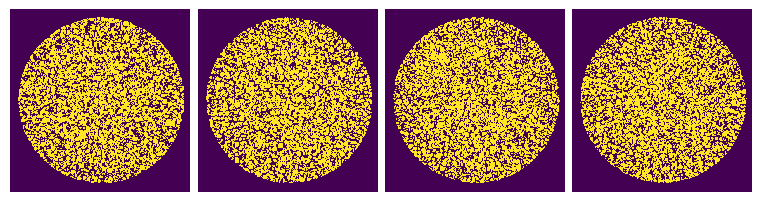

In [4]:
print('Binarizing images...')
# Borders must be excluded after seg. to avoid exclusion of connected regions
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
    imgs_pre, 
    n_otsu_classes=ui_n_otsu_classes, 
    n_selected_thresholds=ui_n_selected_classes, 
    exclude_borders=False, 
)
print('--> Binarization complete')
print('--> Size of array (GB): ', imgs_binarized.nbytes / 1E9)
# Plot binarized images
fig, axes = segment.plot_imgs(imgs_binarized, slices=[100, 150, 200, 250])
plt.show()

## Segment the Images

Segmenting images...
--> Segmentation complete
--> Total number of particles segmented: 28563
Plotting images: [0, 116, 232]


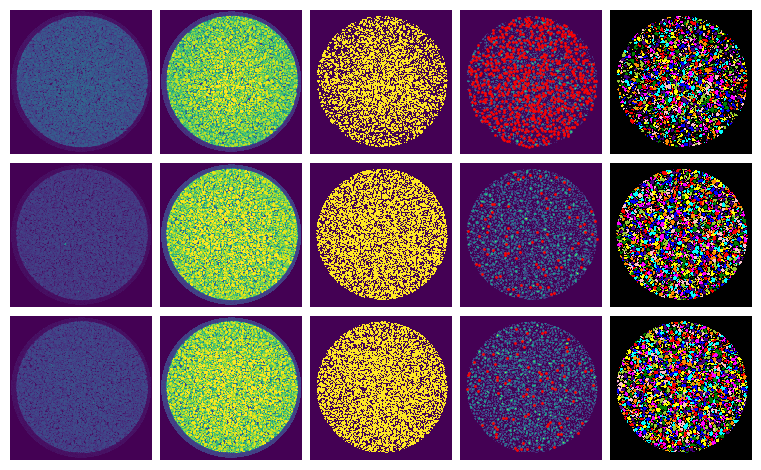

In [5]:
print('Segmenting images...')
segment_dict = segment.watershed_segment(
    imgs_binarized, min_peak_distance=ui_min_peak_distance, 
    use_int_dist_map=ui_use_int_dist_map, return_dict=True
)
print('--> Segmentation complete')
# How Many Particles Were Segmented?
n_particles = np.max(segment_dict['integer-labels'])
n_particles_digits = len(str(n_particles))
print('--> Total number of particles segmented: ' + str(n_particles))
# Plot segmentation results
fig, axes = segment.plot_segment_steps(imgs, imgs_pre, imgs_binarized, segment_dict)
plt.show()

### Exclude border particles

--> Number of particles before border exclusion:  28563

Excluding border particles...
--> Number of particles:  25382
Plotting images: [0, 116, 232]


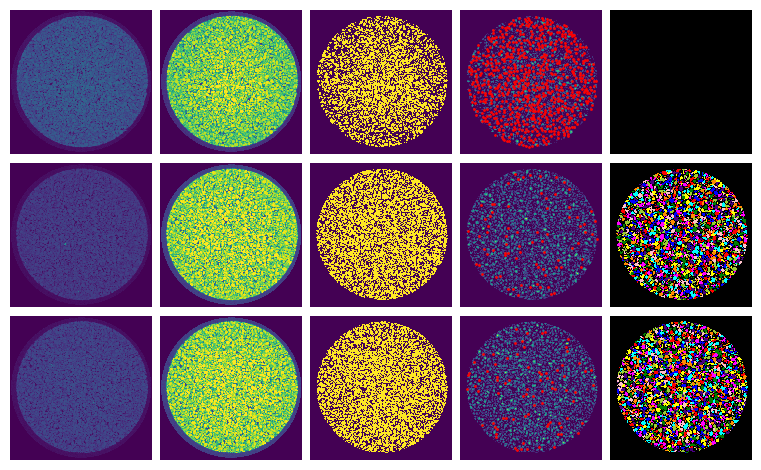

In [6]:
if ui_exclude_borders:
    # How Many Particles Were Segmented?
    n_particles = np.max(segment_dict['integer-labels'])
    n_particles_digits = len(str(n_particles))
    print('--> Number of particles before border exclusion: ', str(n_particles))
    print()
    print('Excluding border particles...')
    segment_dict['integer-labels'] = segmentation.clear_border(
        segment_dict['integer-labels']
    )
regions = measure.regionprops(segment_dict['integer-labels'])
n_particles_noborder = len(regions)
print('--> Number of particles: ', str(n_particles_noborder))
fig, axes = segment.plot_segment_steps(imgs, imgs_pre, imgs_binarized, segment_dict)
plt.show()

Plotting images: [100, 150, 200, 250]


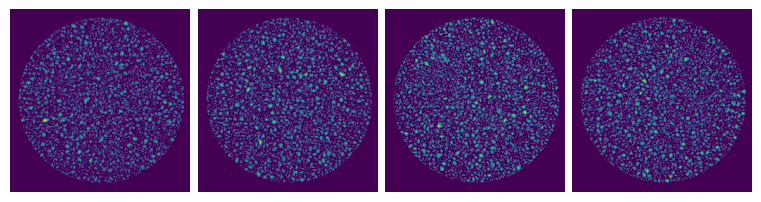

In [10]:
# Plot distance map images
fig, axes = segment.plot_imgs(
        segment_dict['distance-map'], slices=[100, 150, 200, 250])
plt.show()

Plotting images: [100, 150, 200, 250]


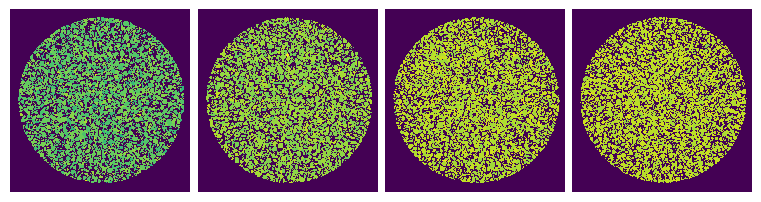

In [13]:
# Plot distance map images
fig, axes = segment.plot_imgs(
        segment_dict['integer-labels'], slices=[100, 150, 200, 250])
plt.show()

## Surface meshing

In [8]:
segment.save_regions_as_stl_files(
    regions,
    ui_stl_dir_location,
    ui_output_filename_base,
    n_particles_digits,
    suppress_save_msg=ui_suppress_save_msg,
    slice_crop=ui_slice_crop,
    row_crop=ui_row_crop,
    col_crop=ui_col_crop,
    stl_overwrite=ui_stl_overwrite,
    spatial_res=ui_spatial_res,
    n_erosions=ui_n_erosions,
    median_filter_voxels=ui_median_filter,
    voxel_step_size=ui_voxel_step_size,
)

Surface mesh not created for particle 942: Particle smaller than minimum width in at least one dimension.
Surface mesh not created for particle 997: No surface found at the given iso value.
Surface mesh not created for particle 1000: No surface found at the given iso value.
Surface mesh not created for particle 1001: No surface found at the given iso value.
Surface mesh not created for particle 1013: No surface found at the given iso value.
Surface mesh not created for particle 1098: No surface found at the given iso value.
Surface mesh not created for particle 1144: No surface found at the given iso value.
Surface mesh not created for particle 1145: No surface found at the given iso value.
Surface mesh not created for particle 1205: No surface found at the given iso value.
Surface mesh not created for particle 1252: No surface found at the given iso value.
Surface mesh not created for particle 1256: No surface found at the given iso value.
Surface mesh not created for particle 1275: N

25028

## Postprocess surface meshes

In [9]:
print('Postprocessing surface meshes...')
if (
        ui_mesh_smooth_n_iters is not None
        or ui_mesh_simplify_n_tris is not None
        or ui_mesh_simplify_factor is not None):
    # Iterate through each STL file, load the mesh, and smooth/simplify
    for stl_path in Path(ui_stl_dir_location).glob('*.stl'):
        stl_mesh, mesh_props = segment.postprocess_mesh(
            stl_path, 
            smooth_iter=ui_mesh_smooth_n_iters, 
            simplify_n_tris=ui_mesh_simplify_n_tris, 
            iterative_simplify_factor=ui_mesh_simplify_factor, 
            recursive_simplify=False, resave_mesh=True
        )

Postprocessing surface meshes...
